# Logistic regression and comparing groups

Idea: Could we any of:
- the Titanic dataset
- the credit scoring dataset (from the lectures)
- the dataset to with depression and body image (from the coursework)

in two ways:

1. Compare differences in means between two groups (hypothesis test)
   - Using bootstrap [TODO]
   - Using t-test - in the end we didn't teach comparing two samples with continuous variables, so I'm not sure we need this.

2. Try to fit a logistic regression model to predict the survival (in Titanic) or credit approval [DRAFTED]

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


## Logistic regression in Titanic dataset

We will return to the position of a historian trying to think about the following question: "Which passenger group had the worst survival rate on the Titanic?". However, now, we rephrase the question as: what factors increased or decreased the odds of survival?

To do this we'll use Logistic Regression.

**Exercise:** Load the dataset, and display a pairplot, using the hue to indicate the response variable, `Survived`.

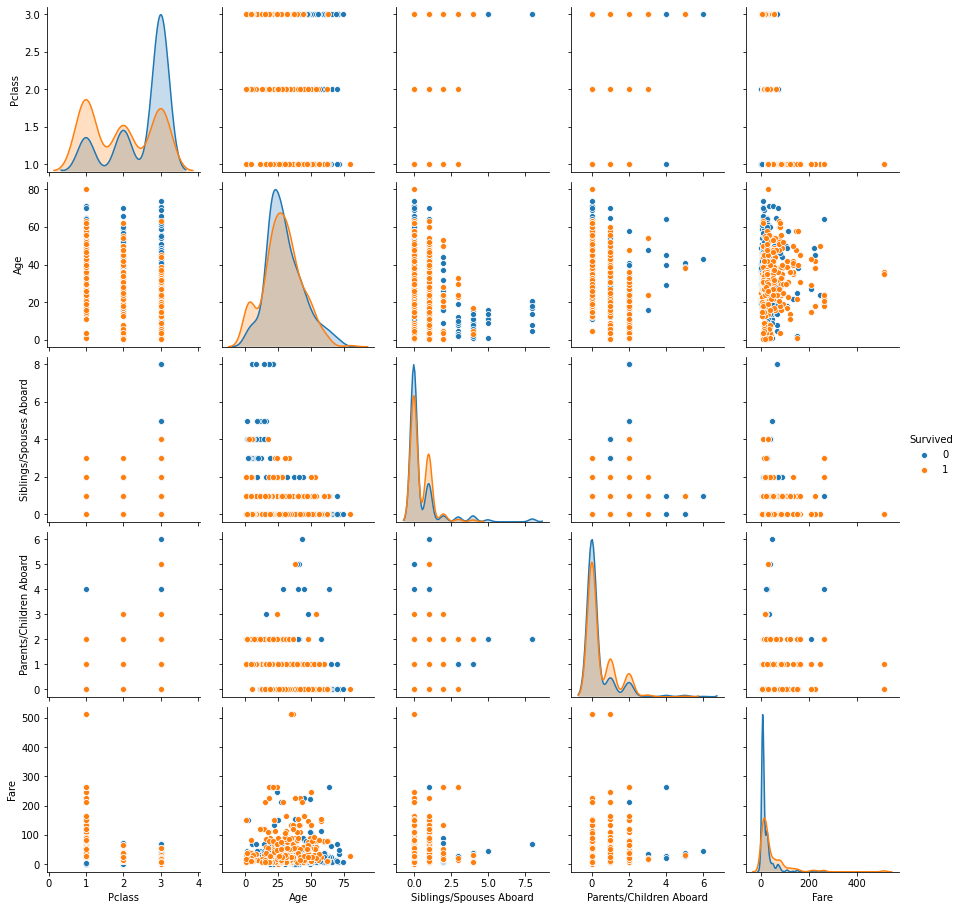

In [2]:
# Your answer
titanic = pd.read_csv('datasets/titanic.csv')
sns.pairplot(titanic, hue='Survived')

## Transform the dataset so logistic regression works better

As with linear regression, logistic regression works better when the variables are more normally distributed. 

**Excercise:** Create a new version of the dataset `titanic_trans`
- Replace the `Fare` variable with a log transformed version of `Fare` called `LogFare`.
- What's the problem with a log transform? 
- Fix the problem by the transform `log(x) + 1`
- Encode female/male in 'Sex' as 0/1 values
- Drop any other non-numeric variables
- Do another pairplot to check the results

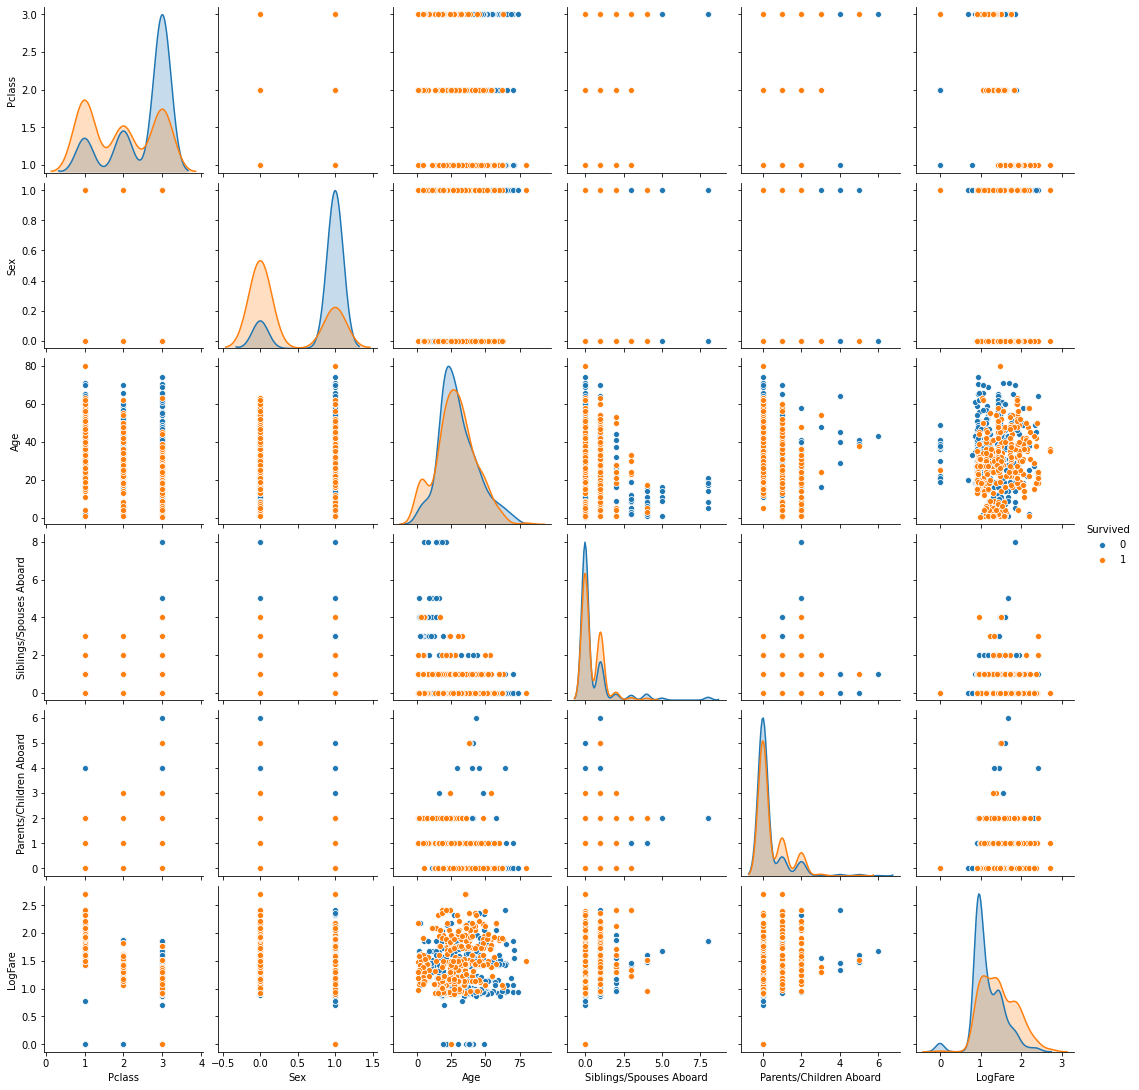

In [3]:
# Your answer
titanic_trans = titanic.copy()
titanic_trans['LogFare'] = np.log10(titanic['Fare'] + 1)
titanic_trans.drop(['Fare', 'Name'], 1, inplace=True)
titanic_trans.replace({'Sex': {'female': 0, 'male': 1}}, inplace=True)
sns.pairplot(titanic_trans, hue='Survived')

## Use sk-learn to run Logistic regression

**Exercise:** Use the `LogisticRegression()` to run logistic regression. You will have to supply a numpy matrix of independent variables and a vector of response variables - the Nearest Neighbours lab may remind you how to do it. 

In [4]:
X = titanic_trans.drop('Survived', 1).to_numpy(copy=True) 
y = titanic_trans['Survived'].to_numpy()
clf = LogisticRegression(random_state=0).fit(X, y)
clf.intercept_
clf.coef_

array([[-0.95071745, -2.6134017 , -0.0432398 , -0.47233219, -0.16652462,
         0.88041393]])

**Exercise:** Interpret the intercept `clf.intercept_`. What quantity does it represent? Describe the characteristics of the passenger for who the independent variables are all zero. Does such a passenger exist?

In [5]:
clf.intercept_

array([3.70170667])

Your answer:

This is the log odds of survival of a newborn female in "zeroeth class" with no siblings and no parents aboard, who paid no fare. It shows that this hypothetical passenger was $e^{3.701}=40.5$ times more likely to survive than die.

**Exercise:** Interpret the coefficients `clf.coef_`. You may find it helpful to convert the output from sklearn back into a pandas Series with an index. Try to use language that you think would be understandable by a general audience. [DCS whacky idea: Paste it into the form here: we will have a poll to decide who made the most understandable interpretation.]

In [6]:
coeffs = pd.Series(clf.coef_[0], index=titanic_trans.columns.drop('Survived'))

In [7]:
coeffs

Pclass                    -0.950717
Sex                       -2.613402
Age                       -0.043240
Siblings/Spouses Aboard   -0.472332
Parents/Children Aboard   -0.166525
LogFare                    0.880414
dtype: float64

In [8]:
np.exp(coeffs)

Pclass                     0.386464
Sex                        0.073285
Age                        0.957682
Siblings/Spouses Aboard    0.623546
Parents/Children Aboard    0.846602
LogFare                    2.411898
dtype: float64

Your answer:

All other things being equal:
- For each class higher, passengers were about 2.6 times (1/0.386) more likely to survive than not - i.e. 1st class passengers were 2.6 times as likely to survive as second class passengers
- Men were 13.6 times less likely to survive than women
- Every year of age meant that your odds of survival to drowning went down by about 4%
- For every sibling or spouse aboard, your odds of survival decreased by a factor of 1.6
- For every sibling or spouse aboard, your odds of survival decreased by a factor of 1.82
- A passenger who paid £100 was 2.5 times as likely to survive as one who paid £10.  

## How many of these coefficients are meaningful?

How likely is it that some of these coefficients could have arisen by chance? We'd like to find confidence intervals for each coefficient. 

**Excercise:** Write a bootstrap function to generate the sampling distribution of all of the coefficients. On each bootstrap iteration, we'd like to store the values of the intercept and all of the coefficients in one row of a dataframe. We'll then be able to plot distribution of the dataframe, and compute confidence intervals from the marginal distributions. We suggest you follow the pattern in the previous lab, and write:
1. A function that takes a dataframe with the same column names as the titanic dataset, fits a logistic regression model to the dataset and returns a pandas series containing the intercept and coefficients from the logistic regression
2. A bootstrap function that takes the above function as `estimator` arguments, and, on each bootstrap replications stores the coefficients in the row of a data frame. It should return the bootstrap samples as a dataframe with an `Intercept` column and then one column for each independent variable. The function doesn't need to return the quantiles or the bootstrap standard error. Note that the column types of the data frame should be `float`.

You can test the first function by making sure it gives you the same results as when you ran the logistic regression on the Titanic dataset above.  Once you've written the function, try it out on the Titanic dataset. You can use the `.quantile()` function on the returned data frame to compute the quantiles. You can also look at a pairplot of the bootstrap samples.

**Note** You may get some warnings from `LogisticRegression` when running the bootstrap. Don't worry about them for now.

In [9]:
# Your answser

def titanic_lr(titanic_trans):
    X = titanic_trans.drop('Survived', 1).to_numpy(copy=True) 
    y = titanic_trans['Survived'].to_numpy()
    clf = LogisticRegression().fit(X, y)
    coeffs = pd.Series(clf.intercept_, index=['Intercept'])
    coeffs = coeffs.append(pd.Series(clf.coef_[0], index=titanic_trans.columns.drop('Survived')))
    return(coeffs)

In [10]:
coeffs = titanic_lr(titanic_trans)

In [11]:
def bootstrap_df(df, k=1000, estimator=titanic_lr):    
    ## Main part of bootstrap
    n = len(df)
    coeffs = estimator(df)
    x_star_est = pd.DataFrame(index=range(k), columns=coeffs.index, dtype='float')
    for i in range(k):
        x_star = df.sample(n, replace=True)
        coeffs_star = estimator(x_star)      
        x_star_est.loc[i] = coeffs_star
    
    return(x_star_est)

In [12]:
coeffs_bs = bootstrap_df(titanic_trans)

/home/dcs/miniconda3/envs/py3iaml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/dcs/miniconda3/envs/py3iaml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

In [13]:
coeffs_bs.quantile([0.025, 0.975])

,Intercept,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,LogFare
0.025,2.273135,-1.266843,-2.998314,-0.060611,-0.733035,-0.383000,0.335078
0.975,5.216824,-0.654597,-2.288709,-0.028851,-0.270026,0.076011,1.548367


In [ ]:
sns.pairplot(coeffs_bs)

**Discussion** What can you conclude from the quantiles? Are any of the relationships you identified earlier open to question, because they may have arisen by chance?

## Fixing the errors

Logistic regression works better with standardised quantities. We can standardise the independent variables and then try fitting logistic regression again. However, the resulting coefficients will themselves be standardised, so we'll need to transform them back, to obtain the true figures. We suggest you just standardise `Age` and `LogFare`. After running the same bootstrap function as above on the transformed data you can transform the parameters back using the formulae $\beta_{Age} = b_{Age}/s_{Age}$, where $b_{Age}$ is the transformed coefficient returned when the bootstrap function is applied to the transformed data. 

In [ ]:
titanic_trans_std = titanic_trans.copy()

In [ ]:
s = titanic_trans_std.std()
xbar = titanic_trans_std.mean()
titanic_trans_std['Age'] = titanic_trans_std['Age'].transform(lambda x: (x - xbar['Age'])/s['Age'])
titanic_trans_std['LogFare'] = titanic_trans_std['LogFare'].transform(lambda x: (x - xbar['LogFare'])/s['LogFare'])

In [ ]:
x_star = bootstrap_df(titanic_trans_std)
x_star['Intercept'] = x_star['Intercept'] - x_star['Age']*xbar['Age']/s['Age'] - x_star['LogFare']*xbar['LogFare']/s['LogFare']
x_star['Age'] = x_star['Age']/s['Age']
x_star['LogFare'] = x_star['LogFare']/s['LogFare']

In [ ]:
sns.pairplot(x_star)

In [ ]:
x_star.quantile([0.025, 0.975])